In [297]:
from __future__ import print_function, division
from builtins import range
from nltk.stem.wordnet import WordNetLemmatizer
# Note: you may need to update your version of future
# sudo pip install -U future

import os
os.chdir('G:/Toxic_Word_Classification/spotify_reviews')
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D,Bidirectional,LSTM,Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# https://lazyprogrammer.me/course_files/toxic_comment_train.csv
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip


# some configuration
MAX_SEQUENCE_LENGTH = 30
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


In [298]:
def specify_ratings(i):
        if i>3:
            return 'Good'
        elif i<3 :
            return 'Bad'
        else:
            return 'Neutral'



print('Loading in comments...')

train = pd.read_csv("G:/Toxic_Word_Classification/spotify_reviews/reviews.csv")

#sentences = train["comment_text"].fillna("DUMMY_VALUE").values
#possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#targets = train[possible_labels].values
ohe=OneHotEncoder()
y=train['Rating'].values
targets=ohe.fit_transform(y.reshape((-1,1)))
targets.shape

y2=train['Rating'].apply(specify_ratings).values
oenc=OrdinalEncoder()
targets2=oenc.fit_transform(y2.reshape((-1,1)))
targets2.shape
targets2

Loading in comments...


array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [299]:
word2vec = {}
with open(os.path.join('G:/Toxic_Word_Classification/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
sentences = train["Review"].fillna("DUMMY_VALUE").values


In [300]:
train

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


In [423]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r"i\'m",'i am',text)
    text=re.sub(r"she\'s",'she is',text)
    text=re.sub(r"that\'s",'that is',text)
    text=re.sub(r"they\'re",'they are',text)
    text=re.sub(r"don\'t",'do not',text)
    text=re.sub(r"doesn\'t",'does not',text)
    text=re.sub(r"hasn\'t",'has not',text)
    text=re.sub(r"hasn\''",'has not',text)
    text=re.sub(r"hadn\'t",'had not',text)
    text=re.sub(r"haven\'t",'have not',text)
    text=re.sub(r"haven\'",'have not',text)
    text=re.sub(r"isn\'t",'is not',text)
    text=re.sub(r"isn\'",'is not',text)
    text=re.sub(r"wasn\'t",'was not',text)
    text=re.sub(r"wasn\'",'was not',text)
    text=re.sub(r"weren\'t",'were not',text)
    text=re.sub(r"weren\'",'were not',text)
    text=re.sub(r"he\'s",'he is',text)
    text=re.sub(r"\'ll",'will',text)
    text=re.sub(r"[-()\"/@/#;:<>{}+=~|?,]","",text)
    return text

clean_text('he doesn\'t')

'he does not'

In [424]:
train_comments_imp=train["Review"].fillna("DUMMY_VALUE").copy()
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
all_stopwords=stopwords.words('english')
all_stopwords.remove('not')
#train_comments_imp_2=train_comments_imp.iloc[:100]
for i in range(train_comments_imp.shape[0]):
    cleaned_txt=clean_text(train_comments_imp.iloc[i])
    comment=re.sub(r'[^a-zA_Z]',' ',cleaned_txt)
    comment=comment.lower()
    comment=comment.split()
    ps= WordNetLemmatizer()
    comment=[ps.lemmatize(word,'v') for word in comment if not word in set(all_stopwords)]
    comment=' '.join(comment)
    train_comments_imp.iloc[i,:]=comment



In [425]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_comments_imp)
sequences = tokenizer.texts_to_sequences(train_comments_imp)
lengths=[]
for i in range(len(sequences)):
    lengths.append(len(sequences[i]))
np.mean(np.array(lengths))

15.87756924375751

In [426]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
word2idx

Found 21748 unique tokens.


{'app': 1,
 'music': 2,
 'not': 3,
 'play': 4,
 'spotify': 5,
 'songs': 6,
 'song': 7,
 'listen': 8,
 'use': 9,
 'like': 10,
 'get': 11,
 'love': 12,
 'premium': 13,
 'good': 14,
 'ads': 15,
 'great': 16,
 'want': 17,
 'playlist': 18,
 'even': 19,
 'update': 20,
 'work': 21,
 'time': 22,
 'fix': 23,
 'stop': 24,
 'go': 25,
 'add': 26,
 'podcast': 27,
 'make': 28,
 'really': 29,
 'pay': 30,
 'please': 31,
 'download': 32,
 'one': 33,
 'best': 34,
 'every': 35,
 'keep': 36,
 'try': 37,
 'phone': 38,
 'would': 39,
 'also': 40,
 'skip': 41,
 'new': 42,
 'give': 43,
 'back': 44,
 'many': 45,
 'find': 46,
 'issue': 47,
 'still': 48,
 'free': 49,
 'annoy': 50,
 'show': 51,
 'need': 52,
 'much': 53,
 'playlists': 54,
 'star': 55,
 'without': 56,
 'say': 57,
 'start': 58,
 'way': 59,
 'better': 60,
 'shuffle': 61,
 'problem': 62,
 'always': 63,
 'years': 64,
 'change': 65,
 'feature': 66,
 'service': 67,
 'easy': 68,
 'pause': 69,
 'experience': 70,
 'know': 71,
 'account': 72,
 'open': 73,
 'l

In [427]:
# put zero at the start if 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


Shape of data tensor: (61594, 30)


In [428]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [429]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


In [430]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Bidirectional(LSTM(20,return_sequences=True))(x)
x = Dropout(0.5)(x)
x=GlobalMaxPooling1D()(x)
output=Dense(3,activation='softmax')(x)
model=Model(input_,output)
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [309]:
aa=targets.shape
targets_n=np.zeros(aa)
for  i in range(aa[0]):
    for j in range(aa[1]):
        targets_n[i,j]=targets[i,j]
        

In [436]:
xtrain,xtest,ytrain,ytest=train_test_split(data,targets2,test_size=0.3)

r = model.fit(
  xtrain,
  ytrain,
  batch_size=BATCH_SIZE,
  epochs=15,
   validation_data=(xtest, ytest)
)





Epoch 1/15
337/337 [==============================] - 14s 43ms/step - loss: 0.5191 - accuracy: 0.8001 - val_loss: 0.5828 - val_accuracy: 0.8000
Epoch 2/15
337/337 [==============================] - 14s 40ms/step - loss: 0.5154 - accuracy: 0.8010 - val_loss: 0.5971 - val_accuracy: 0.7930
Epoch 3/15
337/337 [==============================] - 11s 32ms/step - loss: 0.5128 - accuracy: 0.8020 - val_loss: 0.6063 - val_accuracy: 0.7984
Epoch 4/15
337/337 [==============================] - 12s 35ms/step - loss: 0.5098 - accuracy: 0.8044 - val_loss: 0.5922 - val_accuracy: 0.7952
Epoch 5/15
337/337 [==============================] - 13s 37ms/step - loss: 0.5079 - accuracy: 0.8044 - val_loss: 0.6031 - val_accuracy: 0.7964
Epoch 6/15
337/337 [==============================] - 13s 39ms/step - loss: 0.5048 - accuracy: 0.8053 - val_loss: 0.5920 - val_accuracy: 0.7956
Epoch 7/15
337/337 [==============================] - 12s 37ms/step - loss: 0.5035 - accuracy: 0.8051 - val_loss: 0.6007 - val_accuracy:

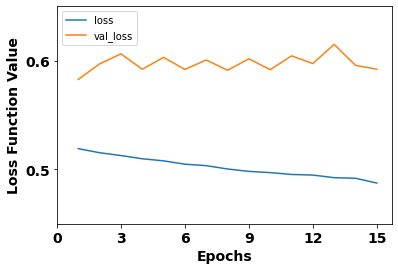

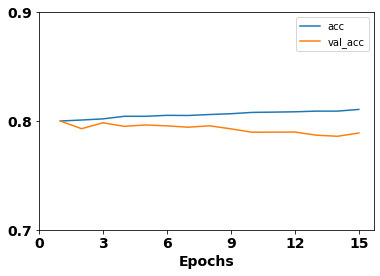

In [438]:
# plot some data
plt.plot(range(1,16),r.history['loss'], label='loss')
plt.plot(range(1,16),r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs',fontweight='bold',fontsize=14)
plt.ylabel('Loss Function Value',fontweight='bold',fontsize=14)
plt.xticks([0,3,6,9,12,15],fontweight='bold',fontsize=14)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1],fontweight='bold',fontsize=14)

plt.ylim([0.45,0.65])
plt.legend()
plt.show()

# accuracies
plt.plot(range(1,16),r.history['accuracy'], label='acc')
plt.plot(range(1,16),r.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs',fontweight='bold',fontsize=14)
plt.xticks([0,3,6,9,12,15],fontweight='bold',fontsize=14)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1],fontweight='bold',fontsize=14)
plt.ylim([0.7,0.9])
plt.legend()
plt.show()

In [432]:

r = model.fit(
  data,
  targets2,
  batch_size=BATCH_SIZE,
  epochs=15
)


Epoch 1/15
482/482 [==============================] - 17s 35ms/step - loss: 0.5553 - accuracy: 0.7861
Epoch 2/15
482/482 [==============================] - 18s 36ms/step - loss: 0.5514 - accuracy: 0.7880
Epoch 3/15
482/482 [==============================] - 17s 36ms/step - loss: 0.5463 - accuracy: 0.7895
Epoch 4/15
482/482 [==============================] - 17s 36ms/step - loss: 0.5445 - accuracy: 0.7908
Epoch 5/15
482/482 [==============================] - 17s 36ms/step - loss: 0.5420 - accuracy: 0.7921
Epoch 6/15
482/482 [==============================] - 16s 34ms/step - loss: 0.5397 - accuracy: 0.7930
Epoch 7/15
482/482 [==============================] - 17s 36ms/step - loss: 0.5372 - accuracy: 0.7941
Epoch 8/15
482/482 [==============================] - 17s 35ms/step - loss: 0.5348 - accuracy: 0.7953
Epoch 9/15
482/482 [==============================] - 17s 36ms/step - loss: 0.5325 - accuracy: 0.7954
Epoch 10/15
482/482 [==============================] - 17s 35ms/step - loss: 0.531

In [435]:
#comment_trial=['high quality device playlist']
#d = {'col1':comment_trial}

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_comments_imp)
sequences = tokenizer.texts_to_sequences(train_comments_imp)



#tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
test_word =["It is an awful app"]
data_trial_t=pd.DataFrame({'col1':test_word})
for i in range(1):
    cleaned_txt=clean_text(data_trial_t.iloc[i].values[0])
    comment=re.sub(r'[^a-zA_Z]',' ',cleaned_txt)
    comment=comment.lower()
    comment=comment.split()
    ps= WordNetLemmatizer()
    comment=[ps.lemmatize(word,'v') for word in comment if not word in set(all_stopwords)]
    comment=' '.join(comment)
    test_word=comment
#tokenizer.fit_on_texts([test_word])
tw = tokenizer.texts_to_sequences([test_word])
#sequence_trial = tokenizer.texts_to_sequences(data_trial_t)
data_trial = pad_sequences(tw, maxlen=MAX_SEQUENCE_LENGTH)
output_trial=model.predict(data_trial)
max=0
k=0
m=3
for i in range(m):
    if output_trial[0,i] > max:
        max=output_trial[0,i]
        ind=i
ind_array=np.array(ind)
print(oenc.inverse_transform(ind_array.reshape((-1,1)))[0][0])

Bad
